In [3]:
# loading dataframes
import numpy as np
import pandas as pd
import json

# system traversal
import os
import re
import zipfile

# seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# plotly html charting
from plotly import tools
import plotly.graph_objs as go
import plotly.plotly as py


# data processing
from sklearn.preprocessing import FunctionTransformer, LabelBinarizer, LabelEncoder, StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline, make_union, FeatureUnion
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.model_selection import train_test_split, GroupKFold
import category_encoders as ce
from xgboost import XGBRegressor

# measurement metrics
from sklearn.metrics import classification_report, make_scorer, mean_squared_error, mean_squared_log_error

# custom classes
from sklearn.base import BaseEstimator, TransformerMixin

# charting paramemters
from pylab import rcParams
rcParams.update({'font.size' : 14, 'legend.fontsize' : "small", 
                 "xtick.labelsize" : 14, "ytick.labelsize" : 14, 
                 "figure.figsize":(9, 6), "axes.titlesize" : 20,
                 "axes.labelsize" : 14, "lines.linewidth" : 3, 
                 "lines.markersize" : 10
                })


## Data import

In [4]:
def json_parse(row):
    return json.loads(row)

json_cols = ['device', 'geoNetwork', 'totals', 'trafficSource']
files = os.listdir('../data/')

print(files)

data = pd.read_csv('../data/' + files[0], converters={'device':json_parse, 'geoNetwork':json_parse, 
                                                      'totals':json_parse, 'trafficSource':json_parse},
                    low_memory = False)

with zipfile.ZipFile(f'../data/{files[0]}') as f:
    print(f.namelist())

['train_proc.zip', 'train.csv.zip', 'test.csv.zip', 'sample_submission.csv.zip']
['final_proc.csv']


In [5]:
data.memory_usage().sum()/1024**2

386.9440813064575

In [72]:
def combine_dict(series):
    
    
    n = len(series)
    final_dict = dict()
    
    def get_keys(series):
   
        n = len(series)
        for i in range(n):
            cur = json.loads(series[i])
            uncommon = final_dict.keys() ^ cur.keys()
            
            if uncommon is not set():
                for item in uncommon:
                    final_dict[item] = []
                
                
        
            
    def proc_cur(cur):
            
        for key in final_dict.keys():
            
            if key not in cur.keys():
                final_dict[key].append(0)
            else:
                final_dict[key].append(cur[key])
    
    get_keys(series)
                        
    for i in range(n):
        cur = json.loads(series[i])
        proc_cur(cur)
        
    return pd.DataFrame(final_dict)

def combine_dict2(series):

    return pd.io.json.json_normalize(series)

In [47]:
%%time
result = combine_dict(data.totals)

CPU times: user 39.6 s, sys: 7.95 ms, total: 39.6 s
Wall time: 39.6 s


In [73]:
%%time
result2 = combine_dict2(data.totals)

CPU times: user 16.4 s, sys: 88 ms, total: 16.4 s
Wall time: 16.5 s


In [50]:
result.head()

,bounces,newVisits,visits,hits,pageviews,transactionRevenue
0,1,1,1,1,1,0
1,1,1,1,1,1,0
2,1,1,1,1,1,0
3,1,1,1,1,1,0
4,1,0,1,1,1,0


In [52]:
result2.fillna(0).head()

,bounces,hits,newVisits,pageviews,transactionRevenue,visits
0,1,1,1,1,0,1
1,1,1,1,1,0,1
2,1,1,1,1,0,1
3,1,1,1,1,0,1
4,1,1,0,1,0,1


In [51]:
result2.fillna(0).equals(result)

False

In [83]:
def proc_data():
    result = [combine_dict2(data[item]) for item in json_cols]
    combined_df = pd.concat(result,axis=1)
    final = pd.merge(data[[col for col in data.columns if col not in json_cols]], 
                     combined_df, left_index=True, right_index = True)
    return final

final = proc_data()

In [85]:
#final.to_csv('../data/processed_train.csv')

(0, 1000000000)

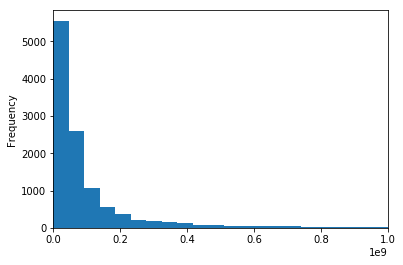

In [81]:
final.transactionRevenue.dropna().astype(int).plot.hist(bins = 500)
plt.xlim(0, 10**9)

In [74]:
final.transactionRevenue.dropna().astype(int).describe()

count    1.151500e+04
mean     1.337448e+08
std      4.482852e+08
min      1.000000e+04
25%      2.493000e+07
50%      4.945000e+07
75%      1.076550e+08
max      2.312950e+10
Name: transactionRevenue, dtype: float64

In [95]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 56 columns):
Unnamed: 0                             903653 non-null int64
channelGrouping                        903653 non-null object
date                                   903653 non-null datetime64[ns]
fullVisitorId                          903653 non-null object
sessionId                              903653 non-null object
socialEngagementType                   903653 non-null object
visitId                                903653 non-null int64
visitNumber                            903653 non-null int64
visitStartTime                         903653 non-null datetime64[ns]
browser                                903653 non-null object
browserSize                            903653 non-null object
browserVersion                         903653 non-null object
deviceCategory                         903653 non-null object
flashVersion                           903653 non-null object
isMobile

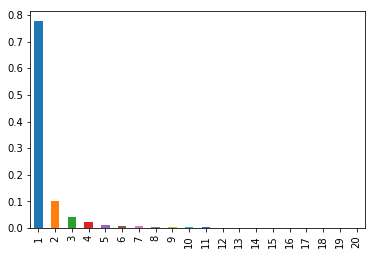

In [131]:
final.visitNumber.value_counts(normalize=True)[0:20].plot.bar()


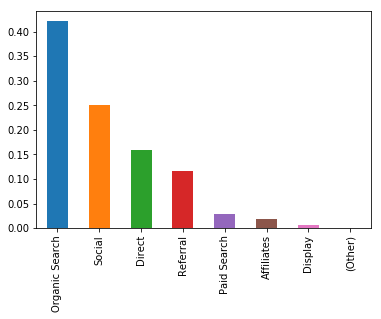

In [132]:
final.channelGrouping.value_counts(normalize=True).plot(kind='bar')

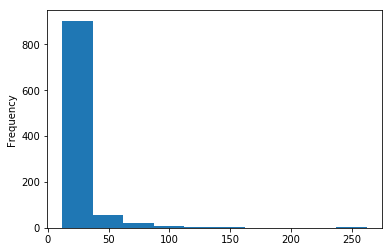

In [142]:
final.fullVisitorId.value_counts()[0:1000].plot(kind='hist')

## Reloading data

In [376]:
# final = final.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
# final.to_csv('../data/final_proc.csv',  index = False)

In [377]:
# %%bash

# cd ..
# cd data
# zip train_proc.zip final_proc.csv
# rm final_proc.csv
# ls

updating: final_proc.csv (deflated 93%)
sample_submission.csv.zip
test.csv.zip
train.csv.zip
train_proc.zip


In [2]:
final = pd.read_csv('../data/train_proc.zip', parse_dates = ['date', 'visitStartTime'], 
                    dtype = {'fullvisitorId':float})
#final.visitStartTime = pd.to_datetime(final.visitStartTime, unit = 's')
#final['campaignCode'] = final.campaignCode.fillna('unknown')

/home/ryeyoo/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



In [3]:
# plotly needs api key to work
with open(os.path.expanduser('~') + '/.plotly/credentials.json', 'r') as infile:
    plotly_key = json.load(infile)
tools.set_credentials_file(username=plotly_key['username'], api_key=plotly_key['api_key'])

## Target value

In [4]:
# plotly charting
data = [go.Histogram(x = final.transactionRevenue.dropna(),
                    xbins=dict(start=0, end=10**9, size = 10000000), 
                    opacity = 0.7
                    )]


layout = go.Layout(title = 'Transaction revenue histogram')
fig = go.Figure(data, layout)
py.iplot(fig)


In [3]:
# Create a trace
trace = go.Scatter(
    x = final.visitNumber.dropna(0).sample(10000),
    y = final.log_transaction.dropna(0).sample(10000),
    mode = 'markers'
)

layout = go.Layout(
    xaxis=dict(
               range = [0,30]
              )
)
data = [trace]

fig = go.Figure(data, layout)
# Plot and embed in ipython notebook!
py.iplot(fig, filename='basic-scatter')


In [5]:
final['has_transaction'] = (final.transactionRevenue.isnull() == False)*1
final['log_transaction'] = np.log1p(final.transactionRevenue)

# Predictors

## Boxplots

In [171]:
from scipy import stats

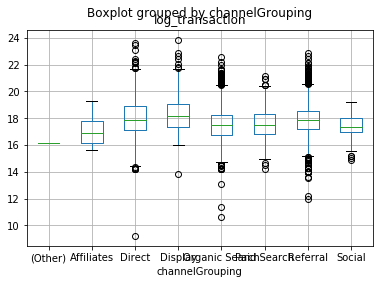

In [324]:
final.boxplot('log_transaction', by = 'channelGrouping')

In [5]:
def find(pattern, string):
    try:
        return re.match(pattern, string).group(0) 
    except:
        pass
    
def num_types(column):
    return len(final[column].value_counts(dropna=False))

In [6]:
col_lens = {col:num_types(col) for col in final.columns.values}

In [7]:
def dict_remove(col_lens):
    remove_list = []
    for key, val in col_lens.items():
        if val == 1:
            remove_list.append(key)

    for item in remove_list:
        col_lens.pop(item)
    return col_lens

In [8]:
col_lens = dict_remove(col_lens)

In [9]:
from pprint import pprint

# print categorical columns

def get_categoricals():
    obj_cols = []
    for i, row in zip(final[list(col_lens.keys())].dtypes.index, final[list(col_lens.keys())].dtypes):
        if row == object and i not in ['fullVisitorId']:
            obj_cols.append(i)
    
    pprint({key:val for key, val in col_lens.items() if key in obj_cols})
    
    return obj_cols

obj_cols = get_categoricals()


{'adContent': 45,
 'adwordsClickInfo.adNetworkType': 3,
 'adwordsClickInfo.gclId': 17775,
 'adwordsClickInfo.isVideoAd': 2,
 'adwordsClickInfo.slot': 3,
 'browser': 54,
 'campaign': 10,
 'campaignCode': 2,
 'channelGrouping': 8,
 'city': 649,
 'continent': 6,
 'country': 222,
 'deviceCategory': 3,
 'isTrueDirect': 2,
 'keyword': 3660,
 'medium': 7,
 'metro': 94,
 'networkDomain': 28064,
 'operatingSystem': 20,
 'referralPath': 1476,
 'region': 376,
 'sessionId': 902755,
 'source': 380,
 'subContinent': 23}


In [10]:
target_cols = ['has_transaction', 'log_transaction', 'transactionRevenue']
num_cols = [col for col in col_lens if col not in obj_cols + ['date', 'visitStartTime'] + target_cols]
final[num_cols] = final[num_cols].fillna(0)

In [11]:
def boxplot(column:str) -> str:
    
    result = final[column].value_counts().iloc[0:10].index
    _ = final[final[column].apply(lambda item: item in result)].boxplot(column = 'log_transaction', by = column)
    _ = plt.xticks(rotation=90)
    _ = plt.title('')
    _ = plt.suptitle(f"log_transaction by {column}")
    _ = plt.xlabel('')


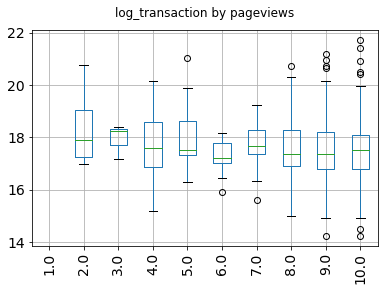

In [65]:
boxplot('pageviews')

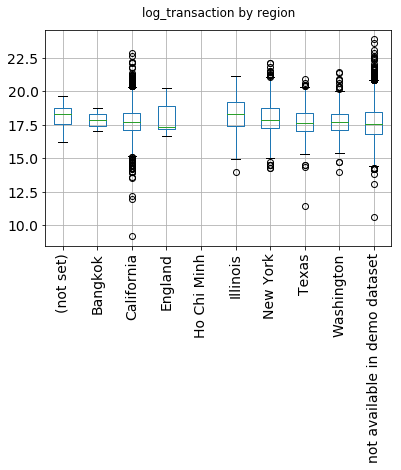

In [66]:
boxplot('region')

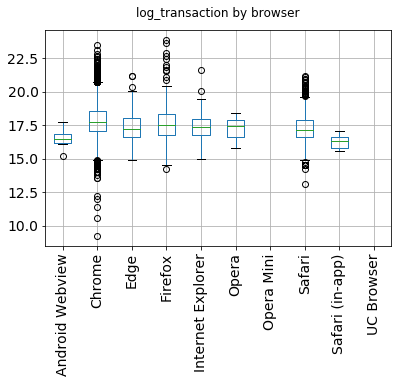

In [67]:
boxplot('browser')

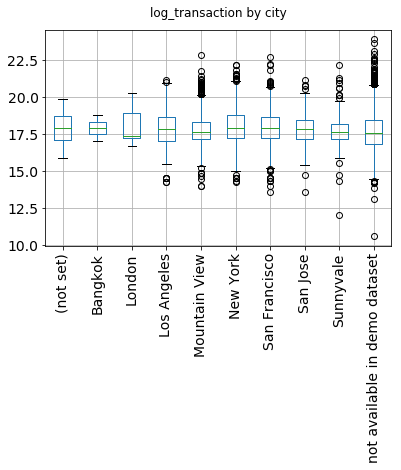

In [68]:
boxplot('city')

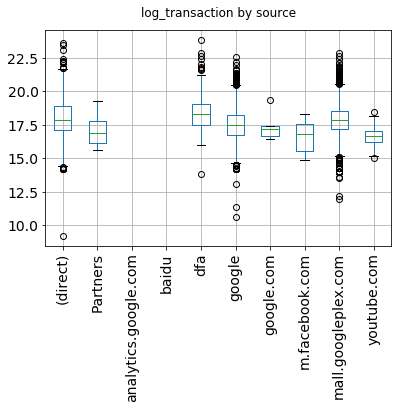

In [69]:
boxplot('source')

In [12]:
feature_cols = [col for col in final.columns if col not in ['transactionRevenue', 'has_transaction', 'log_transaction']]

## Correlation of numeric columns

In [71]:
final[num_cols + ['log_transaction']].corr()

,visitId,visitNumber,isMobile,bounces,hits,newVisits,pageviews,adwordsClickInfo.page,log_transaction
visitId,1.000000,0.002069,0.144332,NaN,-0.027701,NaN,-0.022259,-0.011634,-0.053335
visitNumber,0.002069,1.000000,-0.037667,NaN,0.041317,NaN,0.043363,-0.005168,0.142262
isMobile,0.144332,-0.037667,1.000000,NaN,-0.030367,NaN,-0.030199,0.010172,-0.170131
bounces,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hits,-0.027701,0.041317,-0.030367,NaN,1.000000,NaN,0.983205,-0.011738,0.266041
newVisits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pageviews,-0.022259,0.043363,-0.030199,NaN,0.983205,NaN,1.000000,-0.012944,0.242192
adwordsClickInfo.page,-0.011634,-0.005168,0.010172,NaN,-0.011738,NaN,-0.012944,1.000000,NaN
log_transaction,-0.053335,0.142262,-0.170131,NaN,0.266041,NaN,0.242192,NaN,1.000000


## Feature selection

In [13]:
# from sklearn documentation
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to scikit-learn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [14]:
set(feature_cols) ^ set(num_cols + obj_cols)

{'adwordsClickInfo.criteriaParameters',
 'browserSize',
 'browserVersion',
 'cityId',
 'date',
 'flashVersion',
 'language',
 'latitude',
 'longitude',
 'mobileDeviceBranding',
 'mobileDeviceInfo',
 'mobileDeviceMarketingName',
 'mobileDeviceModel',
 'mobileInputSelector',
 'networkLocation',
 'operatingSystemVersion',
 'screenColors',
 'screenResolution',
 'socialEngagementType',
 'visitStartTime',
 'visits'}

In [28]:
%%time 
result = categorical_pipe.fit_transform(final, final['transactionRevenue'])

KeyboardInterrupt: 

In [79]:
result2 = numerical_pipe.fit_transform(final.fillna(0), final['transactionRevenue'])

In [85]:
final['has_transaction'].value_counts()

0    892138
1     11515
Name: has_transaction, dtype: int64

In [27]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.preprocessing import Imputer
# building model with pipes
categorical_pipe = make_pipeline(ItemSelector(obj_cols), ce.leave_one_out.LeaveOneOutEncoder())
    
#categorical_pipe = make_pipeline(ItemSelector(obj_cols), ce.ordinal.OrdinalEncoder())

#boolean_pipe = make_pipeline(ItemSelector(booleans), ce.one_hot.OneHotEncoder())

numerical_pipe = make_pipeline(ItemSelector(num_cols), RobustScaler())

transform_pipe = \
make_pipeline(
    FeatureUnion(n_jobs = 8, transformer_list = [
        ('cats', categorical_pipe),
        #('bools', boolean_pipe),
        ('nums', numerical_pipe)
        ])
) 

final_pipe = \
make_pipeline(
    FeatureUnion(n_jobs = 8, transformer_list = [
        ('cats', categorical_pipe),
        #('bools', boolean_pipe),
        ('nums', numerical_pipe)
        ]), 
    ExtraTreesClassifier(n_jobs = 8, n_estimators=250,
                              random_state=0)
)

In [123]:
transform_pipe.__dict__['steps'][0][1]

FeatureUnion(n_jobs=8,
       transformer_list=[('cats', Pipeline(memory=None,
     steps=[('itemselector', ItemSelector(key=['channelGrouping', 'sessionId', 'browser', 'deviceCategory', 'operatingSystem', 'city', 'continent', 'country', 'metro', 'networkDomain', 'region', 'subContinent', 'adContent', 'adwordsClickInfo.adNetwork...stScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True))]))],
       transformer_weights=None)

In [170]:
len(obj_cols+num_cols)

33

In [181]:
feature_dict = {num:key for num, key in enumerate(obj_cols+num_cols)}

In [182]:
feature_dict

{0: 'channelGrouping', 1: 'sessionId', 2: 'browser', 3: 'deviceCategory', 4: 'operatingSystem', 5: 'city', 6: 'continent', 7: 'country', 8: 'metro', 9: 'networkDomain', 10: 'region', 11: 'subContinent', 12: 'adContent', 13: 'adwordsClickInfo.adNetworkType', 14: 'adwordsClickInfo.gclId', 15: 'adwordsClickInfo.isVideoAd', 16: 'adwordsClickInfo.slot', 17: 'campaign', 18: 'campaignCode', 19: 'isTrueDirect', 20: 'keyword', 21: 'medium', 22: 'referralPath', 23: 'source', 24: 'fullVisitorId', 25: 'visitId', 26: 'visitNumber', 27: 'isMobile', 28: 'bounces', 29: 'hits', 30: 'newVisits', 31: 'pageviews', 32: 'adwordsClickInfo.page'}

In [142]:
from pprint import pprint
transform_pipe.__dict__['steps'][0][1].__dict__['transformer_list'][0][1].__dict__['steps'][0][1].__dict__

{'key': ['channelGrouping', 'sessionId', 'browser', 'deviceCategory', 'operatingSystem', 'city', 'continent', 'country', 'metro', 'networkDomain', 'region', 'subContinent', 'adContent', 'adwordsClickInfo.adNetworkType', 'adwordsClickInfo.gclId', 'adwordsClickInfo.isVideoAd', 'adwordsClickInfo.slot', 'campaign', 'campaignCode', 'isTrueDirect', 'keyword', 'medium', 'referralPath', 'source']}

1. feature pageviews (0.213363)
2. feature hits (0.172309)
3. feature visitId (0.097445)
4. feature sessionId (0.090241)
5. feature fullVisitorId (0.088626)
6. feature networkDomain (0.057707)
7. feature visitNumber (0.041172)
8. feature city (0.036833)
9. feature metro (0.030266)
10. feature operatingSystem (0.029805)
11. feature region (0.027759)
12. feature browser (0.011878)
13. feature bounces (0.011622)
14. feature country (0.010722)
15. feature newVisits (0.010303)
16. feature continent (0.009713)
17. feature subContinent (0.009511)
18. feature source (0.008337)
19. feature channelGrouping (0.007314)
20. feature isTrueDirect (0.006830)
21. feature medium (0.005875)
22. feature referralPath (0.005775)
23. feature keyword (0.004312)
24. feature deviceCategory (0.003288)
25. feature isMobile (0.003282)
26. feature adwordsClickInfo.gclId (0.003099)
27. feature campaign (0.000833)
28. feature adContent (0.000725)
29. feature adwordsClickInfo.slot (0.000341)
30. feature adwordsClickIn

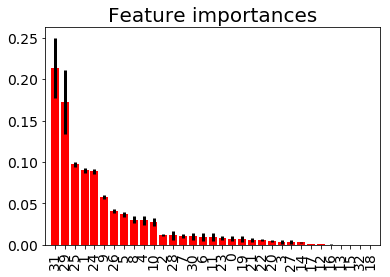

In [184]:
# # http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py
# from collections import OrderedDict

# # Build a forest and compute the feature importances
# forest = ExtraTreesClassifier(n_jobs = 8, n_estimators=250, random_state=0)

# result = transform_pipe.fit_transform(final)
# forest.fit(result, final['has_transaction'])

# importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_],
#              axis=0)
# indices = np.argsort(importances)[::-1]

# # Print the feature ranking
# print("Feature ranking:")

featimp_dict = OrderedDict()
for f in range(result.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, feature_dict[indices[f]], importances[indices[f]]))
    featimp_dict[feature_dict[indices[f]]] = importances[indices[f]]
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(result.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(result.shape[1]), featimp_dict.keys(), rotation = 90)
plt.xlim([-1, result.shape[1]])
plt.show()

In [199]:
rf = RandomForestClassifier(random_state = 42, n_jobs = 8, n_estimators=300)
rf.fit(result, final['has_transaction'])

In [202]:
featimp_dict = {key:val for key, val in zip(obj_cols+num_cols, rf.feature_importances_)}

In [212]:
featimp_dict.get('channelGrouping')

0.006707064626942998

In [218]:
from collections import OrderedDict
from operator import itemgetter
forest_imp_order = OrderedDict(sorted(featimp_dict.items(), key=itemgetter(1), reverse=True))



In [222]:
freq_visitors = final.fullVisitorId.value_counts()[0:20]

In [230]:
final.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,browser,browserSize,...,adwordsClickInfo.slot,campaign,campaignCode,isTrueDirect,keyword,medium,referralPath,source,has_transaction,log_transaction
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,2016-09-02 15:33:05,Chrome,not available in demo dataset,...,NaN,(not set),none,NaN,(not provided),organic,NaN,google,0,NaN
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,2016-09-03 05:22:27,Firefox,not available in demo dataset,...,NaN,(not set),none,NaN,(not provided),organic,NaN,google,0,NaN
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,2016-09-03 01:16:26,Chrome,not available in demo dataset,...,NaN,(not set),none,NaN,(not provided),organic,NaN,google,0,NaN
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,2016-09-03 05:40:13,UC Browser,not available in demo dataset,...,NaN,(not set),none,NaN,google + online,organic,NaN,google,0,NaN
4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,2016-09-02 13:23:20,Chrome,not available in demo dataset,...,NaN,(not set),none,True,(not provided),organic,NaN,google,0,NaN


In [231]:
visitor_example = final[final.fullVisitorId == freq_visitors.index[0]].sort_values('visitStartTime')

In [236]:
visitor_example.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'browser', 'browserSize', 'browserVersion', 'deviceCategory',
       'flashVersion', 'isMobile', 'language', 'mobileDeviceBranding',
       'mobileDeviceInfo', 'mobileDeviceMarketingName', 'mobileDeviceModel',
       'mobileInputSelector', 'operatingSystem', 'operatingSystemVersion',
       'screenColors', 'screenResolution', 'city', 'cityId', 'continent',
       'country', 'latitude', 'longitude', 'metro', 'networkDomain',
       'networkLocation', 'region', 'subContinent', 'bounces', 'hits',
       'newVisits', 'pageviews', 'transactionRevenue', 'visits', 'adContent',
       'adwordsClickInfo.adNetworkType', 'adwordsClickInfo.criteriaParameters',
       'adwordsClickInfo.gclId', 'adwordsClickInfo.isVideoAd',
       'adwordsClickInfo.page', 'adwordsClickInfo.slot', 'campaign',
       'campaignCode', 'isTrueDirect', 'keyword', 'medium', 'refe

In [5]:
sns.set_style('whitegrid')


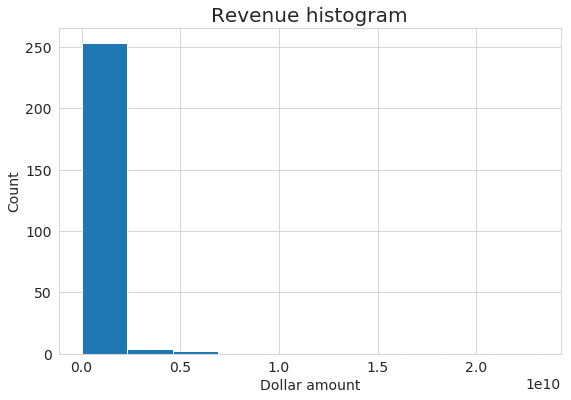

In [290]:
_ = visitor_example[['visitStartTime', 'transactionRevenue']].fillna(0).hist(figsize=(9,6))
_ = plt.xlabel('Dollar amount')
_ = plt.ylabel('Count')
_ = plt.title('Revenue histogram')

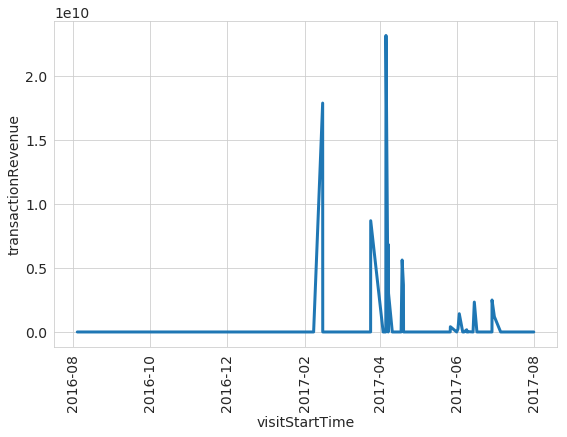

In [296]:
_ = plt.figure(figsize = (9,6))
_ = sns.lineplot(x = 'visitStartTime', y = 'transactionRevenue', data = visitor_example[['visitStartTime', 'transactionRevenue']].fillna(0))
_ = plt.xticks(rotation = 90)

